Total representative sequences: 40


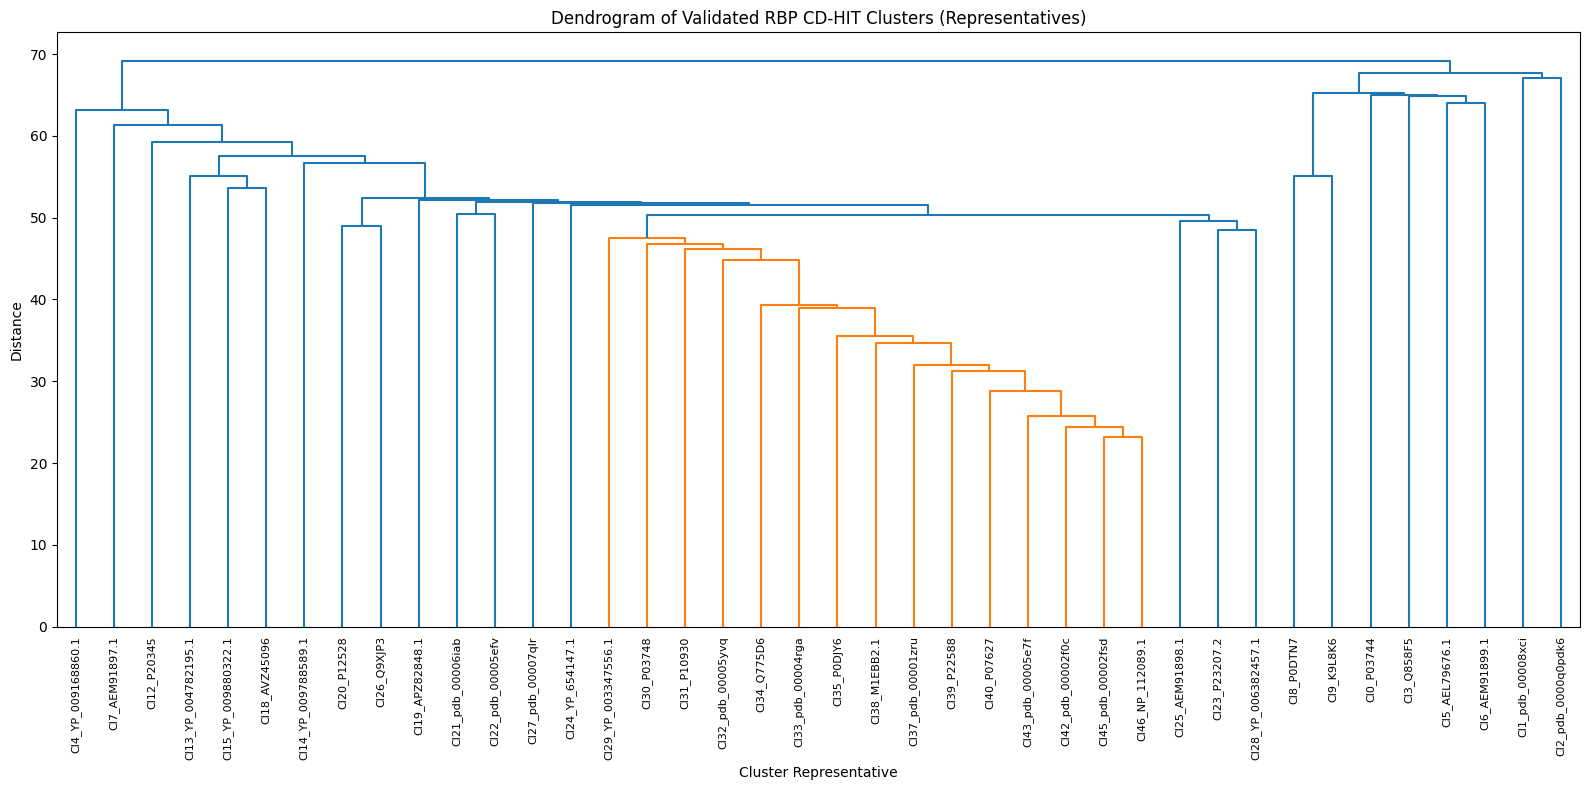

In [17]:
from Bio import SeqIO
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# === 1. Parse CD-HIT output ===
def parse_cdhit_output(file_path):
    clusters = {}
    current_cluster = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(">Cluster"):
                current_cluster = line.split(" ")[1]
                clusters[current_cluster] = []
            elif current_cluster and '>' in line:
                try:
                    seq_info = line.split(",")[1] if ',' in line else line
                    seq_id = seq_info.split(">")[1].split("...")[0].strip()
                    clusters[current_cluster].append(seq_id)
                except Exception as e:
                    print(f"Error parsing line: {line}\n{e}")
    return clusters

# === 2. Load sequences from FASTA ===
def load_fasta_sequences(fasta_path):
    seq_dict = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        seq_dict[record.id] = str(record.seq)
    return seq_dict

# === 3. Extract representative sequences ===
def get_representative_sequences(clusters, seq_dict):
    sequences, ids, cluster_ids = [], [], []
    for cluster_id, seq_ids in clusters.items():
        if seq_ids:
            rep_id = seq_ids[0]
            seq = seq_dict.get(rep_id, "")
            if seq:
                sequences.append(seq)
                ids.append(rep_id)
                cluster_ids.append(cluster_id)
            else:
                print(f"Warning: {rep_id} not found in FASTA.")
    return sequences, ids, cluster_ids

# === MAIN ===
if __name__ == "__main__":
    cluster_file = "cluster_validadas.txt"
    fasta_file = "validated_RBP.fasta"

    clusters = parse_cdhit_output(cluster_file)
    seq_dict = load_fasta_sequences(fasta_file)
    sequences, ids, cluster_ids = get_representative_sequences(clusters, seq_dict)

    print(f"Total representative sequences: {len(sequences)}")

    # Vectorize using k-mer presence
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 4))
    X0 = vectorizer.fit_transform(sequences)

    # Hierarchical clustering
    Z = linkage(X0.toarray(), method='ward')

    # Dendrogram
    labels = [f"Cl{cl}_{sid}" for cl, sid in zip(cluster_ids, ids)]
    plt.figure(figsize=(16, 8))
    dendrogram(Z, labels=labels, leaf_rotation=90)
    plt.title('Dendrogram of Validated RBP CD-HIT Clusters (Representatives)')
    plt.xlabel('Cluster Representative')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

Total representative sequences: 237


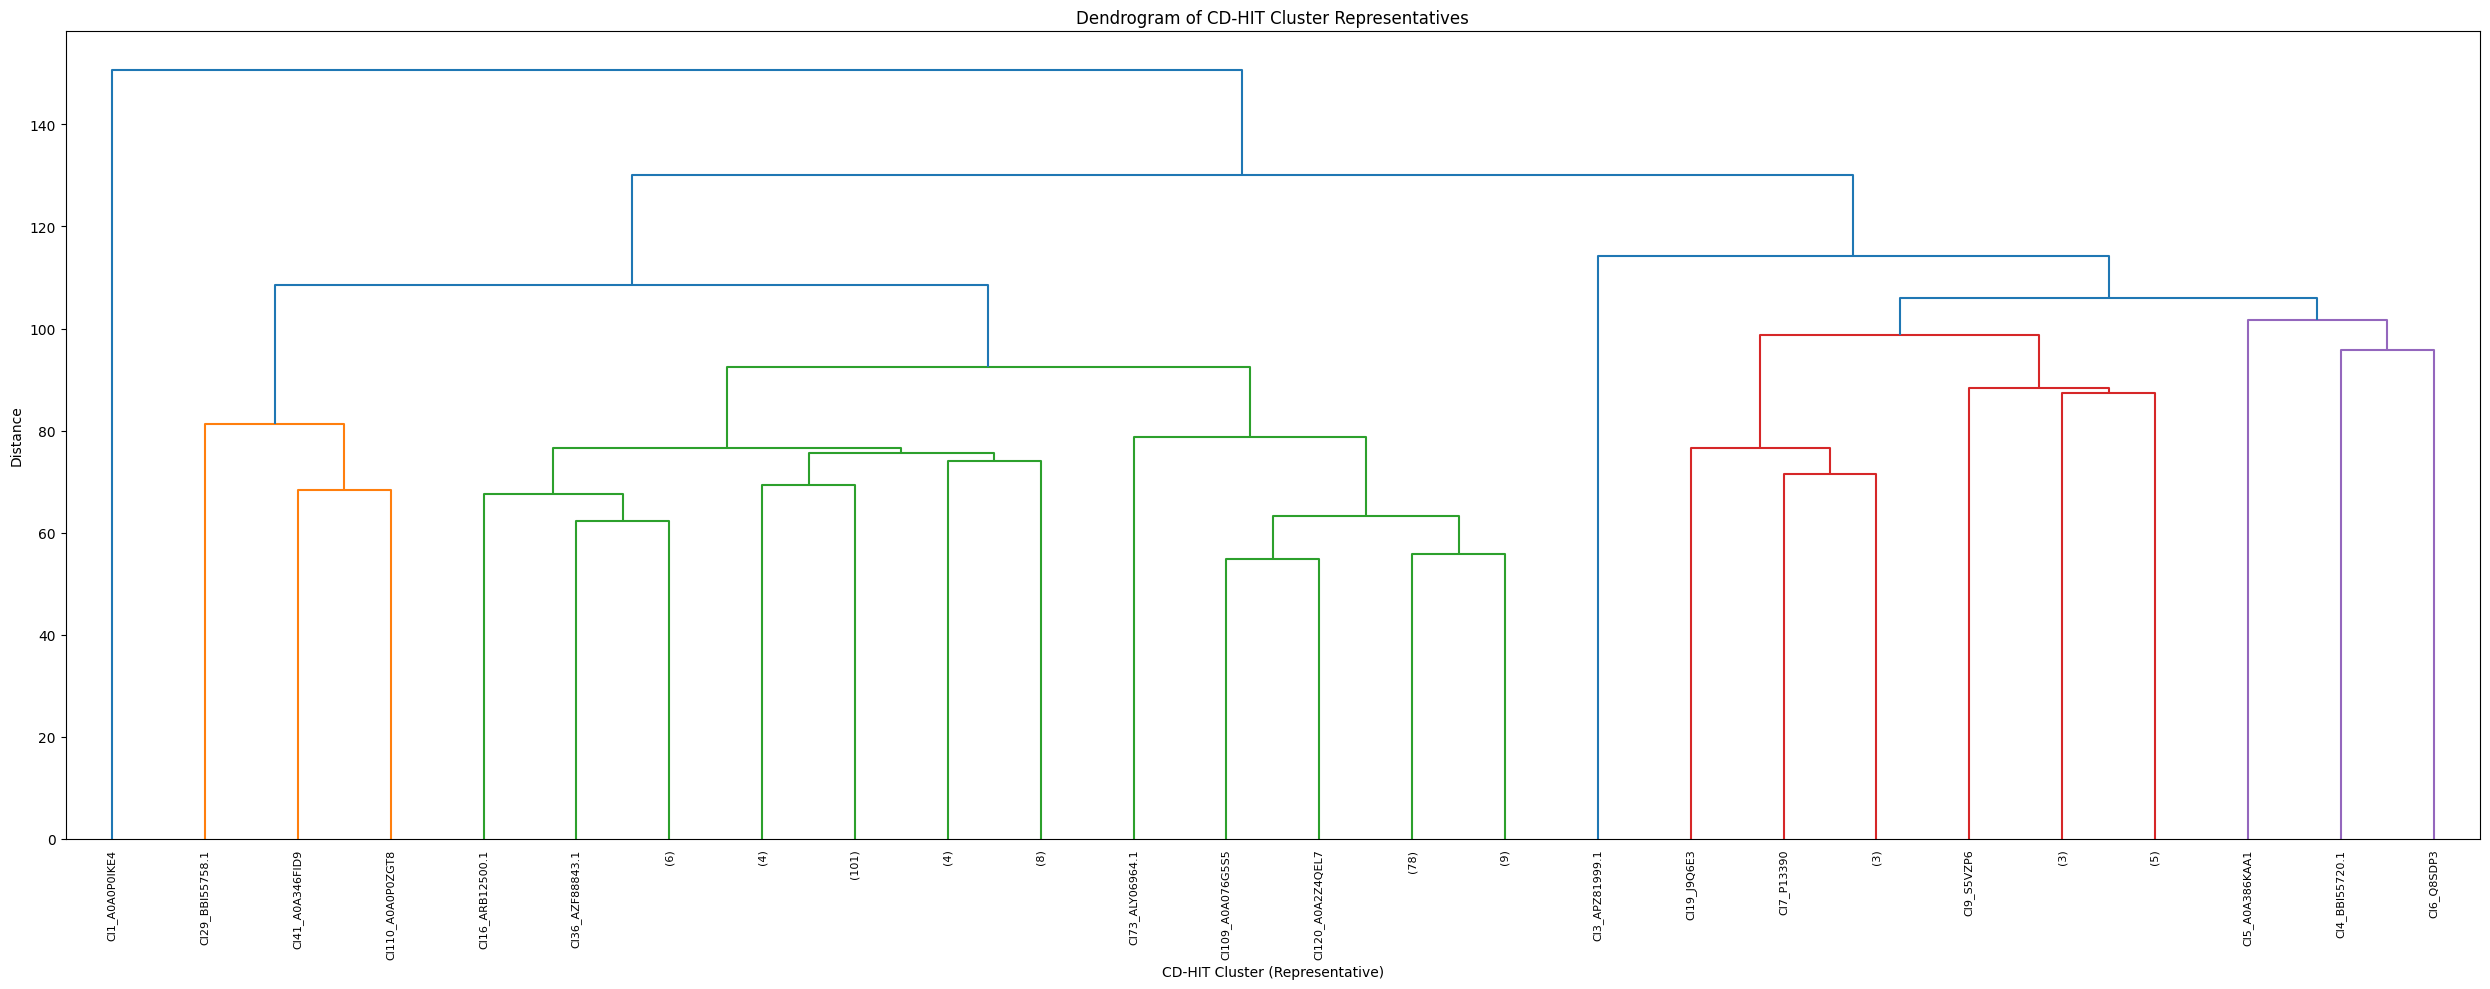

In [27]:
import pandas as pd
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# === 1. Parse CD-HIT cluster file ===
def parse_cdhit_output(file_path):
    clusters = {}
    current_cluster = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(">Cluster"):
                current_cluster = line.split(" ")[1]
                clusters[current_cluster] = []
            elif current_cluster is not None and line:
                if '>' in line:
                    try:
                        seq_info = line.split(",")[1] if ',' in line else line
                        seq_id_part = seq_info.split(">")[1]
                        seq_id = seq_id_part.split("...")[0].strip()
                        if seq_id:
                            clusters[current_cluster].append(seq_id)
                    except Exception as e:
                        print(f"Error parsing line: {line}\n{e}")
    return clusters

# === 2. Load sequences from FASTA ===
def load_fasta_sequences(fasta_path):
    seq_dict = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        core_id = record.id
        seq_dict[core_id] = str(record.seq)
    return seq_dict

# === 3. Select one representative per cluster ===
def get_representative_sequences(clusters, seq_dict):
    rep_sequences = []
    rep_ids = []
    rep_cluster_ids = []

    for cluster_id, seq_ids in clusters.items():
        if seq_ids:
            rep_id = seq_ids[0]
            seq = seq_dict.get(rep_id, "")
            if seq:
                rep_sequences.append(seq)
                rep_ids.append(rep_id)
                rep_cluster_ids.append(cluster_id)
            else:
                print(f"Warning: Sequence for {rep_id} not found.")
    return rep_sequences, rep_ids, rep_cluster_ids

# === MAIN PIPELINE ===
if __name__ == "__main__":
    cluster_file = "cluster_both.txt"       # CD-HIT output
    fasta_file = "unique_phage_proteins1.fasta"  # Sequences used in CD-HIT

    # Step 1: Parse CD-HIT clusters
    clusters = parse_cdhit_output(cluster_file)

    # Step 2: Load sequences
    seq_dict = load_fasta_sequences(fasta_file)

    # Step 3: Get representative sequences
    rep_sequences, rep_ids, rep_cluster_ids = get_representative_sequences(clusters, seq_dict)

    print(f"Total representative sequences: {len(rep_sequences)}")

    # Step 4: Vectorize with k-mer counts (3-4mers)
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 4))
    X1 = vectorizer.fit_transform(rep_sequences)

    # Step 5: Hierarchical clustering
    Z = linkage(X1.toarray(), method='ward')

    # Step 6: Dendrogram visualization
    labels = [f"Cl{cl}_{sid}" for cl, sid in zip(rep_cluster_ids, rep_ids)]
    plt.figure(figsize=(25, 10))
    dendrogram(Z, labels=labels, truncate_mode='level', p=6, leaf_rotation=90)   
    plt.xticks(rotation=90, size=8)
    plt.title('Dendrogram of CD-HIT Cluster Representatives')
    plt.xlabel('CD-HIT Cluster (Representative)')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()


In [19]:
import pandas as pd
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import linkage
import plotly.figure_factory as ff
import random

# === 1. Parse CD-HIT cluster file ===
def parse_cdhit_output(file_path):
    clusters = {}
    current_cluster = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(">Cluster"):
                current_cluster = line.split(" ")[1]
                clusters[current_cluster] = []
            elif current_cluster is not None and line:
                if '>' in line:
                    try:
                        seq_info = line.split(",")[1] if ',' in line else line
                        seq_id_part = seq_info.split(">")[1]
                        seq_id = seq_id_part.split("...")[0].strip()
                        if seq_id:
                            clusters[current_cluster].append(seq_id)
                    except Exception as e:
                        print(f"Error parsing line: {line}\n{e}")
    return clusters

# === 2. Load sequences from FASTA ===
def load_fasta_sequences(fasta_path):
    seq_dict = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        core_id = record.id
        seq_dict[core_id] = str(record.seq)
    return seq_dict

# === 3. Select one representative per cluster ===
def get_representative_sequences(clusters, seq_dict):
    rep_sequences = []
    rep_ids = []
    rep_cluster_ids = []

    for cluster_id, seq_ids in clusters.items():
        if seq_ids:
            rep_id = seq_ids[0]  # Take first sequence as representative
            seq = seq_dict.get(rep_id, "")
            if seq:
                rep_sequences.append(seq)
                rep_ids.append(rep_id)
                rep_cluster_ids.append(cluster_id)
            else:
                print(f"Warning: Sequence for {rep_id} not found.")
    return rep_sequences, rep_ids, rep_cluster_ids

if __name__ == "__main__":
    cluster_file = "cluster_both.txt"  # CD-HIT output file
    fasta_file = "unique_phage_proteins1.fasta"  # FASTA sequences

    # Step 1: Parse CD-HIT clusters
    clusters = parse_cdhit_output(cluster_file)

    # Step 2: Load sequences from FASTA
    seq_dict = load_fasta_sequences(fasta_file)

    # Step 3: Get representatives
    rep_sequences, rep_ids, rep_cluster_ids = get_representative_sequences(clusters, seq_dict)

    print(f"Total representative sequences: {len(rep_sequences)}")

    # Optional: If too many reps, sample a subset for visualization clarity
    sample_size = 50
    if len(rep_sequences) > sample_size:
        sampled_indices = random.sample(range(len(rep_sequences)), sample_size)
        rep_sequences = [rep_sequences[i] for i in sampled_indices]
        rep_ids = [rep_ids[i] for i in sampled_indices]
        rep_cluster_ids = [rep_cluster_ids[i] for i in sampled_indices]

    # Step 4: Vectorize with k-mer counts (3-4 mers)
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 4))
    X1 = vectorizer.fit_transform(rep_sequences)

    # Step 5: Hierarchical clustering
    Z = linkage(X1.toarray(), method='ward')

    # Step 6: Dendrogram with Plotly
    labels = [f"Cl{cl}_{sid}" for cl, sid in zip(rep_cluster_ids, rep_ids)]

    fig = ff.create_dendrogram(X1.toarray(), linkagefun=lambda x: Z, labels=labels)
    fig.update_layout(
        width=1200,
        height=600,
        title="Dendrogram of CD-HIT Cluster Representatives - Both datasets",
        xaxis_title="Sequence (Cluster_SequenceID)",
        yaxis_title="Distance"
    )
    fig.show()


Total representative sequences: 237


Total representative sequences parsed: 213


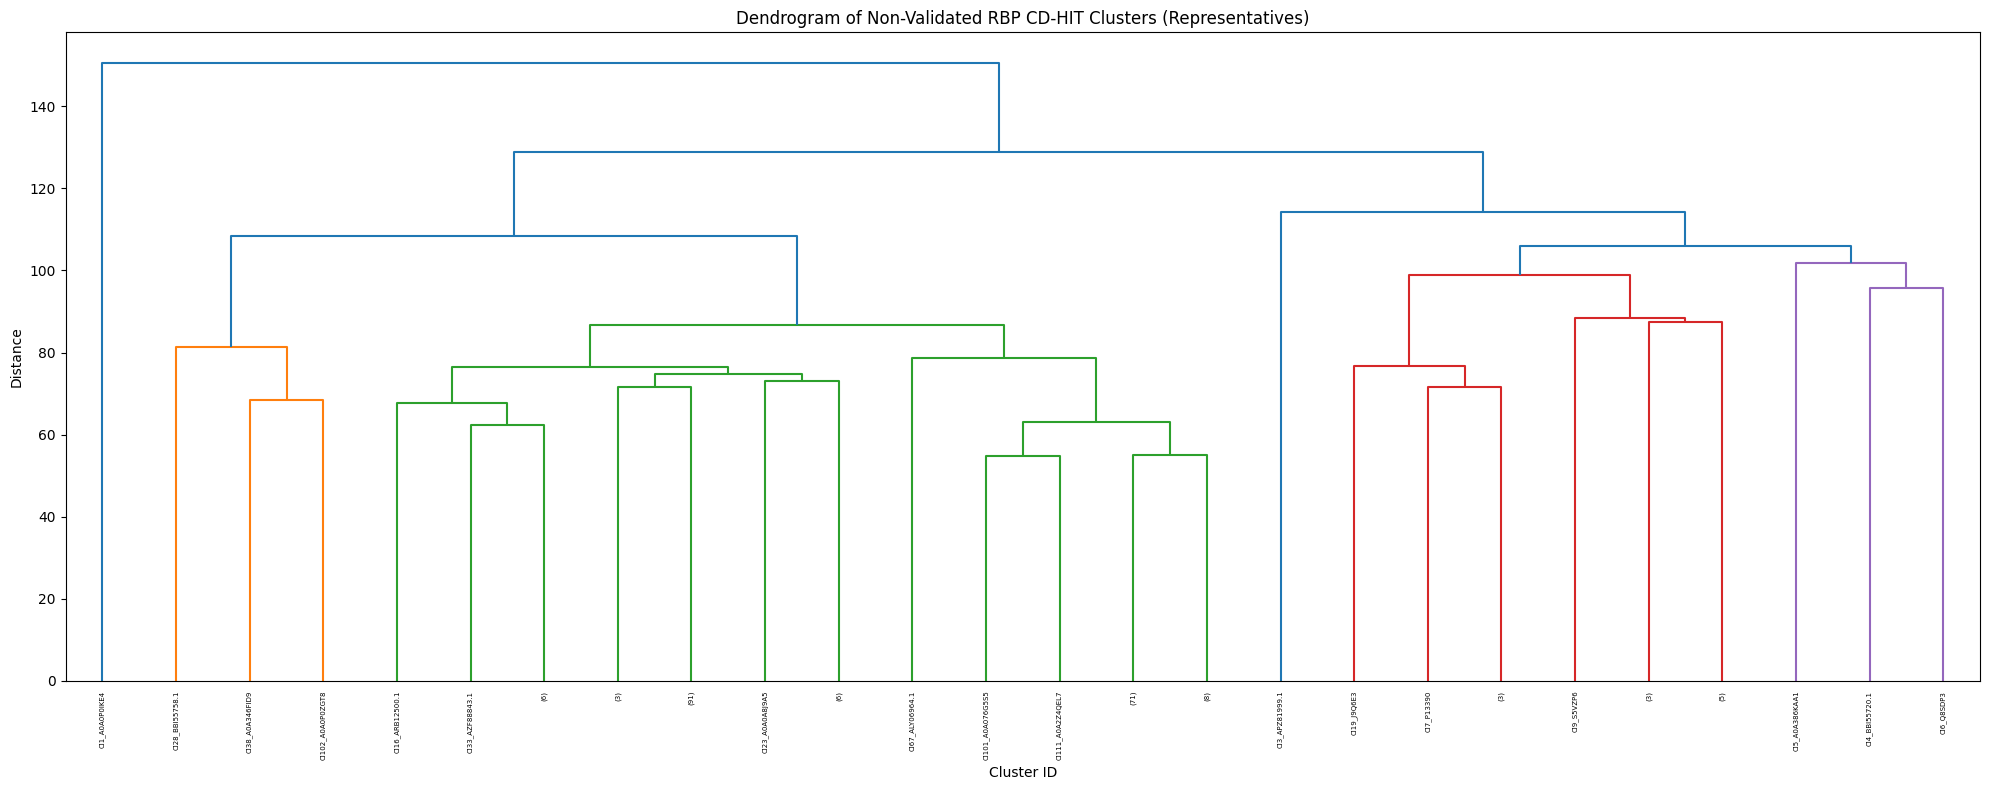

In [22]:
from Bio import SeqIO
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# === 1. Parse CD-HIT output ===
def parse_cdhit_output(file_path):
    clusters = {}
    current_cluster = None
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(">Cluster"):
                current_cluster = line.split(" ")[1]
                clusters[current_cluster] = []
            elif current_cluster and '>' in line:
                try:
                    seq_info = line.split(",")[1] if ',' in line else line
                    seq_id = seq_info.split(">")[1].split("...")[0].strip()
                    clusters[current_cluster].append(seq_id)
                except Exception as e:
                    print(f"Error parsing line: {line}\n{e}")
    return clusters

# === 2. Load sequences from FASTA ===
def load_fasta_sequences(fasta_path):
    seq_dict = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        seq_dict[record.id] = str(record.seq)
    return seq_dict

# === 3. Extract representative sequences only ===
def get_representative_sequences(clusters, seq_dict):
    sequences, ids, cluster_ids = [], [], []
    for cluster_id, seq_ids in clusters.items():
        if seq_ids:
            rep_id = seq_ids[0]
            seq = seq_dict.get(rep_id, "")
            if seq:
                sequences.append(seq)
                ids.append(rep_id)
                cluster_ids.append(cluster_id)
            else:
                print(f"Warning: {rep_id} not found in FASTA.")
    return sequences, ids, cluster_ids

# === MAIN ===
if __name__ == "__main__":
    cluster_file = "cluster_naovalidadas.txt"
    fasta_file = "unique_phage_proteins2.fasta"

    clusters = parse_cdhit_output(cluster_file)
    seq_dict = load_fasta_sequences(fasta_file)
    sequences, ids, cluster_ids = get_representative_sequences(clusters, seq_dict)

    print(f"Total representative sequences parsed: {len(sequences)}")

    df = pd.DataFrame({
        "Cluster": cluster_ids,
        "Sequence ID": ids,
        "Sequence": sequences
    })
    df.to_csv("clustered_sequences2_representatives.csv", index=False)

    # Vectorize using k-mer counts
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 4))
    X = vectorizer.fit_transform(sequences)

    # Hierarchical clustering
    Z = linkage(X.toarray(), method='ward')

    # Dendrogram
    labels = [f"Cl{cl}_{sid}" for cl, sid in zip(cluster_ids, ids)]
    plt.figure(figsize=(20, 8))
    dendrogram(Z, labels=labels, truncate_mode='level', p=6, leaf_rotation=90)
    plt.xticks(rotation=90, size=5)
    plt.title('Dendrogram of Non-Validated RBP CD-HIT Clusters (Representatives)')
    plt.xlabel('Cluster ID')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()


Total representative sequences parsed: 213


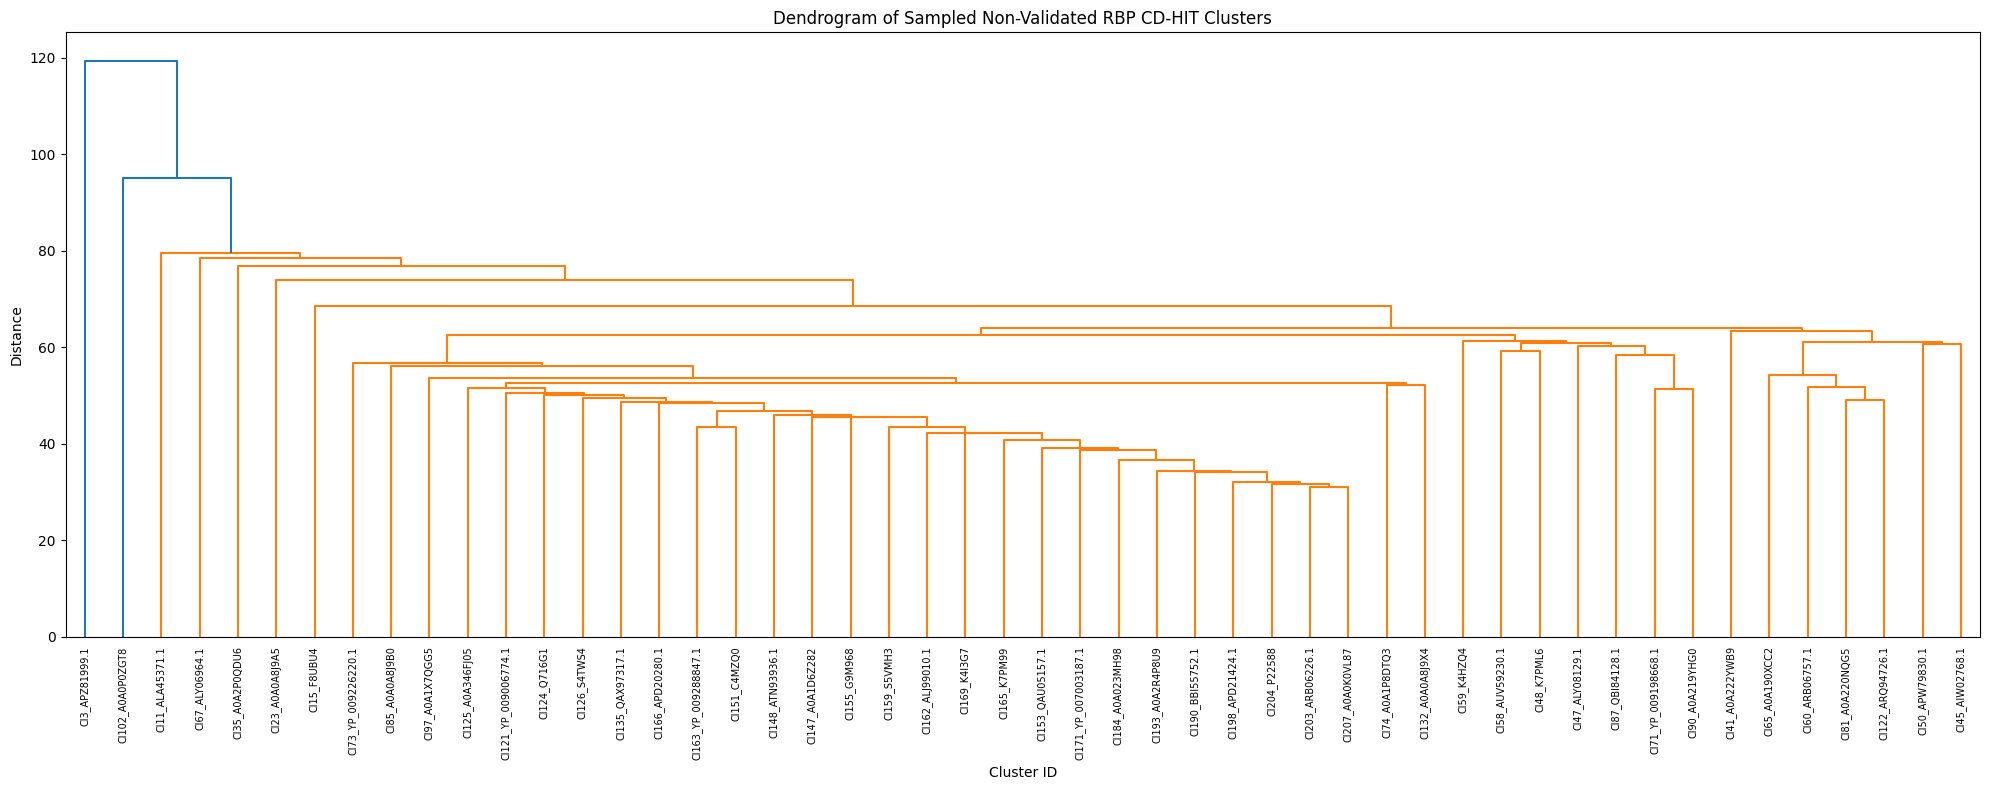

In [21]:
from Bio import SeqIO
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import random

# === 1. Parse CD-HIT output ===
def parse_cdhit_output(file_path):
    clusters = {}
    current_cluster = None
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(">Cluster"):
                current_cluster = line.split(" ")[1]
                clusters[current_cluster] = []
            elif current_cluster and '>' in line:
                try:
                    seq_info = line.split(",")[1] if ',' in line else line
                    seq_id = seq_info.split(">")[1].split("...")[0].strip()
                    clusters[current_cluster].append(seq_id)
                except Exception as e:
                    print(f"Error parsing line: {line}\n{e}")
    return clusters

# === 2. Load sequences from FASTA ===
def load_fasta_sequences(fasta_path):
    seq_dict = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        seq_dict[record.id] = str(record.seq)
    return seq_dict

# === 3. Extract representative sequences only ===
def get_representative_sequences(clusters, seq_dict):
    sequences, ids, cluster_ids = [], [], []
    for cluster_id, seq_ids in clusters.items():
        if seq_ids:
            rep_id = seq_ids[0]
            seq = seq_dict.get(rep_id, "")
            if seq:
                sequences.append(seq)
                ids.append(rep_id)
                cluster_ids.append(cluster_id)
            else:
                print(f"Warning: {rep_id} not found in FASTA.")
    return sequences, ids, cluster_ids

# === MAIN ===
if __name__ == "__main__":
    cluster_file = "cluster_naovalidadas.txt"
    fasta_file = "unique_phage_proteins2.fasta"

    clusters = parse_cdhit_output(cluster_file)
    seq_dict = load_fasta_sequences(fasta_file)
    sequences, ids, cluster_ids = get_representative_sequences(clusters, seq_dict)

    print(f"Total representative sequences parsed: {len(sequences)}")

    # === RANDOM SAMPLING OF REPRESENTATIVES ===
    sample_size = 50  # adjust as needed
    if len(sequences) > sample_size:
        sampled_indices = random.sample(range(len(sequences)), sample_size)
        sequences = [sequences[i] for i in sampled_indices]
        ids = [ids[i] for i in sampled_indices]
        cluster_ids = [cluster_ids[i] for i in sampled_indices]

    # Save to CSV
    df = pd.DataFrame({
        "Cluster": cluster_ids,
        "Sequence ID": ids,
        "Sequence": sequences
    })
    df.to_csv("clustered_sequences2_representatives_sampled.csv", index=False)

    # Vectorize using k-mer counts
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 4))
    X = vectorizer.fit_transform(sequences)

    # Hierarchical clustering
    Z = linkage(X.toarray(), method='ward')

    # Dendrogram
    labels = [f"Cl{cl}_{sid}" for cl, sid in zip(cluster_ids, ids)]
    plt.figure(figsize=(20, 8))
    dendrogram(Z, labels=labels, leaf_rotation=90)
    plt.xticks(rotation=90, size=7)
    plt.title('Dendrogram of Sampled Non-Validated RBP CD-HIT Clusters')
    plt.xlabel('Cluster ID')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()
